In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load the sample data
nhis_data_sample = pd.read_csv('./data/nhis_data_sample.csv')

In [3]:
class ModelTrainer:
    def __init__(self, data):
        self.data = data
        self.results = {}

    def preprocess_data(self, features):
        data_features = self.data.dropna(subset=features + ['diabetes_status'])
        X = data_features[features]
        y = data_features['diabetes_status']
        return X, y

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, feature, model_name, model):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        self.results[feature][model_name] = {
            "classification_report": report,
            "confusion_matrix": cm
        }

    def process_feature(self, feature):
        X, y = self.preprocess_data([feature])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        self.results[feature] = {}

        self.train_and_evaluate(X_train, X_test, y_train, y_test, feature, 'Logistic Regression', LogisticRegression(max_iter=1000))
        self.train_and_evaluate(X_train, X_test, y_train, y_test, feature, 'Decision Tree', DecisionTreeClassifier())
        self.train_and_evaluate(X_train, X_test, y_train, y_test, feature, 'Random Forest', RandomForestClassifier(n_estimators=100))

    def process_all_features(self, features):
        for feature in features:
            self.process_feature(feature)

    def process_combined_features(self, features):
        X, y = self.preprocess_data(features)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        combined_feature_name = 'Combined Features'
        self.results[combined_feature_name] = {}

        self.train_and_evaluate(X_train, X_test, y_train, y_test, combined_feature_name, 'Logistic Regression', LogisticRegression(max_iter=1000))
        self.train_and_evaluate(X_train, X_test, y_train, y_test, combined_feature_name, 'Decision Tree', DecisionTreeClassifier())
        self.train_and_evaluate(X_train, X_test, y_train, y_test, combined_feature_name, 'Random Forest', RandomForestClassifier(n_estimators=100))

    def __str__(self):
        output = ""
        for feature, model_results in self.results.items():
            output += f"Results for Feature: {feature}\n"
            output += "=" * 80 + "\n"
            for model_name, results in model_results.items():
                output += f"{model_name} Results:\n"
                output += "-" * 80 + "\n"
                output += "Classification Report:\n"
                for label, metrics in results['classification_report'].items():
                    if isinstance(metrics, dict):
                        output += f"  Class {label}:\n"
                        for metric, value in metrics.items():
                            output += f"    {metric}: {value:.4f}\n"
                    else:
                        output += f"  {label}: {metrics:.4f}\n"
                output += "\nConfusion Matrix:\n"
                output += f"{results['confusion_matrix']}\n"
                output += "-" * 80 + "\n"
            output += "=" * 80 + "\n\n"
        return output

In [4]:
# Feature Selection
features = [
    'age_code', 'total_cholesterol', 'triglycerides', 'hdl_cholesterol', 
    'ldl_cholesterol', 'systolic_bp', 'diastolic_bp', 'serum_creatinine', 
    'weight', 'waist_circum'
]

In [5]:
# Initialize and process the data
trainer = ModelTrainer(nhis_data_sample)
trainer.process_all_features(features)

# Process combined features
trainer.process_combined_features(features)

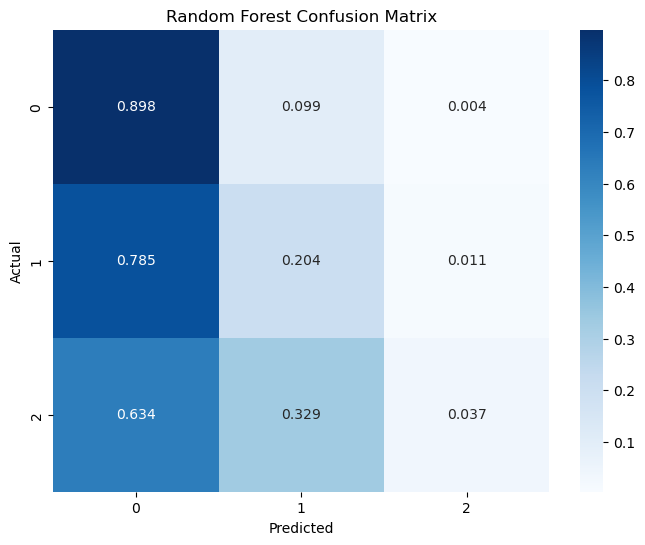

In [20]:
# Visualize the confusion matrix for the combined features
cm = trainer.results['Combined Features']['Random Forest']['confusion_matrix']

# Convert the values to percentages of predicted values
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

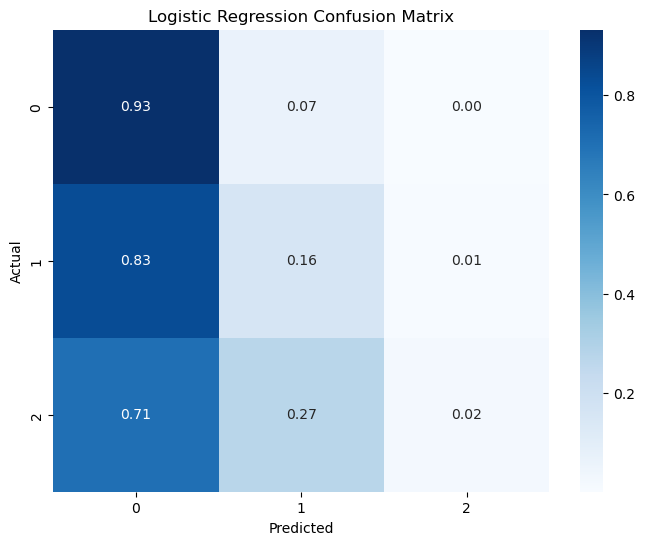

In [9]:
# Visualize the confusion matrix for the combined features - logistic regression
cm = trainer.results['Combined Features']['Logistic Regression']['confusion_matrix']

# Convert the values to percentages of actual values
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

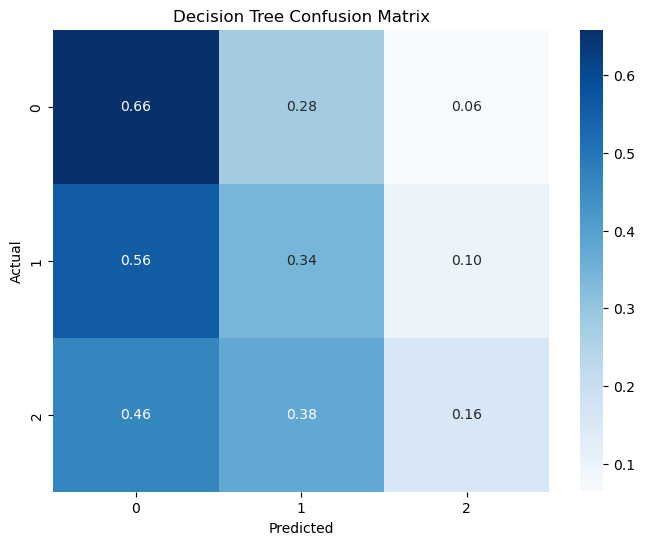

In [10]:
# Visualize the confusion matrix for the combined features - decision tree
cm = trainer.results['Combined Features']['Decision Tree']['confusion_matrix']

# Convert the values to percentages of actual values
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [39]:
# Calculate the percentages of true positives, false positives, true negatives, and false negatives for the combined features - random forest
cm_rf = trainer.results['Combined Features']['Random Forest']['confusion_matrix']
tp_rf = (cm_rf[1, 1] + cm_rf[2, 2]) / cm_rf.sum()
fp_rf = (cm_rf[0, 1] + cm_rf[0, 2] + cm_rf[1, 2]) / cm_rf.sum()
tn_rf = cm_rf[0, 0] / cm_rf.sum()
fn_rf = (cm_rf[1, 0] + cm_rf[2, 0] + cm_rf[2, 1]) / cm_rf.sum()

# Print the percentages
for metric, value in zip(['TP (+)', 'FP (-)', 'TN (+)', 'FN (-)'], [tp_rf, fp_rf, tn_rf, fn_rf]):
    print(f"{metric}: {value:.4f}")
print("=" * 14)

# Calculate the percentages of true positives, false positives, true negatives, and false negatives for the combined features - logistic regression
cm_lr = trainer.results['Combined Features']['Logistic Regression']['confusion_matrix']
tp_lr = (cm_lr[1, 1] + cm_lr[2, 2]) / cm_lr.sum()
fp_lr = (cm_lr[0, 1] + cm_lr[0, 2] + cm_lr[1, 2]) / cm_lr.sum()
tn_lr = cm_lr[0, 0] / cm_lr.sum()
fn_lr = (cm_lr[1, 0] + cm_lr[2, 0] + cm_lr[2, 1]) / cm_lr.sum()

# Print the percentages
for metric, value in zip(['TP (+)', 'FP (-)', 'TN (+)', 'FN (-)'], [tp_lr, fp_lr, tn_lr, fn_lr]):
    print(f"{metric}: {value:.4f}")
print("=" * 14)

# Calculate the percentages of true positives, false positives, true negatives, and false negatives for the combined features - decision tree
cm_dt = trainer.results['Combined Features']['Decision Tree']['confusion_matrix']
tp_dt = (cm_dt[1, 1] + cm_dt[2, 2]) / cm_dt.sum()
fp_dt = (cm_dt[0, 1] + cm_dt[0, 2] + cm_dt[1, 2]) / cm_dt.sum()
tn_dt = cm_dt[0, 0] / cm_dt.sum()
fn_dt = (cm_dt[1, 0] + cm_dt[2, 0] + cm_dt[2, 1]) / cm_dt.sum()

# Print the percentages
for metric, value in zip(['TP (+)', 'FP (-)', 'TN (+)', 'FN (-)'], [tp_dt, fp_dt, tn_dt, fn_dt]):
    print(f"{metric}: {value:.4f}")

TP (+): 0.0628
FP (-): 0.0679
TN (+): 0.5664
FN (-): 0.3029
TP (+): 0.0489
FP (-): 0.0449
TN (+): 0.5878
FN (-): 0.3184
TP (+): 0.1126
FP (-): 0.2447
TN (+): 0.4156
FN (-): 0.2271
